In [1]:
library("dplyr")
library("fusca")
library("igraph")
library("scales")
library("ggplot2")
library("Seurat")
library("IRdisplay")
library("OmnipathR")
library("gprofiler2")
library("circlize")
library("RColorBrewer")
library(tidyverse)
library(viridis)
library(tidyr)
library(patchwork)
library(hrbrthemes)
library(circlize)
library(chorddiag)
library(foreach)


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union



Attachement du package : ‘igraph’


Les objets suivants sont masqués depuis ‘package:dplyr’:

    as_data_frame, groups, union


Les objets suivants sont masqués depuis ‘package:stats’:

    decompose, spectrum


L'objet suivant est masqué depuis ‘package:base’:

    union


Attaching SeuratObject

Attaching sp

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))



Attachement du package : ‘circlize’


L'objet sui

# Function rewrite

In [2]:
createPPI <- function(expr, data){
  a <- expr
  #data <- as.data.frame(import_omnipath_interactions(datasets = 'omnipath', entity_types = 'protein'))
  cat(dim(data))
  cat('\nProtein interaction data loaded!')
  # The columns names are usually fixed.
  ppi <- data[, c('source_genesymbol','target_genesymbol', 'curation_effort')] #geneA and geneB, score
  idmap <- data.frame(idA=ppi$source_genesymbol, idB=ppi$target_genesymbol, score=as.numeric(ppi$curation_effort))
  allgenes <- unique(c(as.vector(idmap$idA), as.vector(idmap$idB)))
  inetwork <- igraph::graph.data.frame(idmap, directed=FALSE);
  inetwork <- igraph::simplify(inetwork, remove.multiple = TRUE,
                               remove.loops = TRUE)
  genesPPI <- intersect(rownames(expr), allgenes)
  remove <- setdiff(igraph::V(inetwork)$name, rownames(expr))
  inetwork <- igraph::delete.vertices(inetwork, remove)
  ctable <- as.data.frame(igraph::get.edgelist(inetwork))
  colnames(ctable) <- c('from', 'to')
  names <- paste(as.vector(ctable$from), as.vector(ctable$to), sep="_")
  rownames(ctable) <- names
  network <- list(network=inetwork, ctable=ctable, table=idmap, genes=allgenes,
                  genesPPI=genesPPI, removed=remove)
  return(network)
}

In [3]:
cellnetworksPPI2 <- function(ppi, expr, samples, corThr1, corThr2, column,
                             dir.prefix='results/paths'){
  corTables <- list()
  for(celltype in as.vector(unique(samples[[column]]))){
    print(celltype)
    tmp <- samples[which(samples[[column]] == celltype),]
    if(nrow(tmp) < 4) next #it needs to contain at all 3 cells/spots to calculate a correlation.
    tmp.expr <- expr[igraph::V(ppi)$name, rownames(tmp)]
    var <- apply(tmp.expr, 1, var)
    tmp.expr <- tmp.expr[which(var > 0),]
    cor <- cor(t(as.data.frame(as.matrix((tmp.expr)))))
    print(range(cor))
    cor[cor < corThr1] <- 0
    cor_g <- igraph::graph_from_adjacency_matrix(cor, mode='undirected',
                                                 weighted = 'correlation')
    cor.m <- igraph::as_data_frame(cor_g, 'edges')
    rownames(cor.m) <- paste(as.vector(cor.m$from), as.vector(cor.m$to), sep='_')
    #overlap of edges
    el <- igraph::get.edgelist(ppi)
    rownames(el) <- paste(el[,1], el[,2], sep='_')
    keep <- intersect(rownames(cor.m), rownames(el))
    cor.m2 <- cor.m[keep,]
    cor.m2 <- cor.m2[which(cor.m2$correlation > corThr2),]
    if (nrow(cor.m2) == 0) {
        print(paste0("No correlation found for ", celltype, " cell type."))
        gc()
    }
    else {
        network <- igraph::graph.data.frame(cor.m2, directed=FALSE);
        igraph::E(network)$weight  <- as.vector(cor.m2$correlation)
        network <- igraph::simplify(network, remove.multiple = TRUE,
                                    remove.loops = TRUE)
        edges <- as.data.frame(igraph::get.edgelist(network))
        edges$weight <- abs(igraph::E(network)$weight)
        edges$corr <- igraph::E(network)$weight
        celltype <- gsub(" ", ".", celltype)
        filename <- paste(dir.prefix, celltype, '.txt',sep='')
        write.table(edges, file=filename, sep='\t', row.names=FALSE,
                    col.names = FALSE, quote=FALSE) #input network
        gc()
        corTables[[celltype]] <- network
        gc(verbose=TRUE)
    }
  }
  return(corTables)
}

In [4]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

In [5]:
embryo<-readRDS("/home/adufour/work/rds_storage/immuneall_v3.rds")

In [6]:
counts <- GetAssayData(embryo, slot="data", assay="RNA") 

In [7]:
cellrouter <- CreateCellRouter(counts, assay.type = "RNA", min.genes = 100, min.cells = 25, is.expr = 0)

[1] 12945 34888


In [8]:
regulons_filtered <- readRDS("/home/adufour/work/rds_storage/SCENIC/regulons_filterby_rss.rds")

In [9]:
regulons_filtered <- unique(regulons_filtered$regulons)

In [10]:
tfs <- gsub(" (+)", "", regulons_filtered, ignore.case = FALSE, perl = FALSE, fixed = TRUE, useBytes = FALSE)

In [11]:
embryo@meta.data$cell_type[embryo@meta.data$cell_type == "Trophectoderme ?"] <- "Trophectoderme2"
embryo@meta.data$cell_type[embryo@meta.data$cell_type == "Trophectoderme 1"] <- "Trophectoderme1"
embryo@meta.data$cell_type[embryo@meta.data$cell_type == "Trophectoderme 2"] <- "Trophectoderme2"
embryo@meta.data$cell_type[embryo@meta.data$cell_type == "Trophectoderme 3"] <- "Trophectoderme3"
embryo@meta.data$cell_type[embryo@meta.data$cell_type == "Endoderme 1"] <- "Endoderme1"
embryo@meta.data$cell_type[embryo@meta.data$cell_type == "Endoderme 2"] <- "Endoderme2"
embryo@meta.data$cell_type[embryo@meta.data$cell_type == "Endoderme 3"] <- "Endoderme3"

In [12]:
embryo@meta.data$cell_type_time <- paste0(embryo@meta.data$cell_type, "-", embryo@meta.data$TIME)

In [13]:
cellrouter@assays$RNA@sampTab$celltype <- embryo@meta.data$cell_type_time

In [14]:
liana_results <- readRDS("/home/adufour/work/rds_storage/LR/liana/liana_result.rds")

In [15]:
liana_results <- liana_results[,c("ligand","receptor")]

In [16]:
colnames(liana_results) <- c("from", "to")

In [17]:
lr_network <- liana_results

In [18]:
pairs <- lr_network
pairs$Pair.Name <- paste(pairs$from, pairs$to, sep = "_")

ligands <- unique(lr_network$from)
ligands <- intersect(ligands, rownames(cellrouter@assays$RNA@ndata))

In [19]:
receptors <- unique(lr_network$to)
receptors <- intersect(receptors, rownames(cellrouter@assays$RNA@ndata))

ligands.receptors <- unique(c(ligands, receptors))

mean.expr <- computeValue(cellrouter, assay.type = "RNA", 
                          genelist = ligands.receptors, "celltype", fun = "mean"); gc();

[1] "discovering subpopulation-specific gene signatures"
cluster  ICM-J5 
cluster  Trophectoderme-J5 
cluster  Trophectoderme-J7 
cluster  Endoderme-J7 
cluster  Epiblaste-J7 
cluster  Endoderme-J9 
cluster  Trophectoderme3-J9 
cluster  Epiblaste-J9 
cluster  Trophectoderme2-J9 
cluster  Trophectoderme1-J9 
cluster  Endoderme1-J11 
cluster  Trophectoderme1-J11 
cluster  Endoderme2-J11 
cluster  Trophectoderme2-J11 
cluster  Mesendoderme-J11 
cluster  Endoderme3-J11 
cluster  Epiblaste-J11 
cluster  Trophectoderme3-J11 


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3750560,200.4,7378580,394.1,4804181,256.6
Vcells,132413326,1010.3,244514309,1865.5,244499808,1865.4


In [20]:
interactions <- population.pairing(mean.expr = mean.expr, pairs = pairs, ligands = ligands, receptors = receptors, threshold = 0.25)

interactions <- calculateObservedMean(mean.expr = mean.expr, interactions = interactions)
head(interactions)

markers <- findSignatures(cellrouter, assay.type = "RNA", column = "celltype", pos.only = TRUE, fc.threshold = 0.2)

gc()

,celltype1,celltype2,pair,ligand,receptor,mean.ligand,mean.receptor,mean
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,ICM-J5,ICM-J5,ANGPT2_KIT,ANGPT2,KIT,0.4161095,0.8007487,0.6084291
2,ICM-J5,ICM-J5,PDGFA_KIT,PDGFA,KIT,0.2632777,0.8007487,0.5320132
3,ICM-J5,ICM-J5,ENSSSCG00000013038_KIT,ENSSSCG00000013038,KIT,0.2642070,0.8007487,0.5324779
4,ICM-J5,ICM-J5,ADAM10_IL6R,ADAM10,IL6R,0.4886790,0.4428360,0.4657575
5,ICM-J5,ICM-J5,ANGPT2_ERBB3,ANGPT2,ERBB3,0.4161095,0.7299634,0.5730364
6,ICM-J5,ICM-J5,CDH1_ERBB3,CDH1,ERBB3,0.7400880,0.7299634,0.7350257


Calculating fold changes... 
[1] "Identify cluster-specific gene signatures"
cluster  ICM-J5 
[1] 2266
cluster  Trophectoderme-J5 
[1] 584
cluster  Trophectoderme-J7 
[1] 554
cluster  Endoderme-J7 
[1] 570
cluster  Epiblaste-J7 
[1] 1021
cluster  Endoderme-J9 
[1] 403
cluster  Trophectoderme3-J9 
[1] 1032
cluster  Epiblaste-J9 
[1] 841
cluster  Trophectoderme2-J9 
[1] 494
cluster  Trophectoderme1-J9 
[1] 339
cluster  Endoderme1-J11 
[1] 298
cluster  Trophectoderme1-J11 
[1] 488
cluster  Endoderme2-J11 
[1] 731
cluster  Trophectoderme2-J11 
[1] 523
cluster  Mesendoderme-J11 
[1] 617
cluster  Endoderme3-J11 
[1] 672
cluster  Epiblaste-J11 
[1] 918
cluster  Trophectoderme3-J11 
[1] 174
[1] "finding subpopulation markers"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3772778,201.5,7378580,394.1,7378580,394.1
Vcells,133520181,1018.7,352285690,2687.8,352285690,2687.8


In [21]:
genelist <- unique(c(interactions$ligand, interactions$receptor))

p <- clusterPermutation(cellrouter, assay.type = "RNA", 
                        genelist = genelist, interactions = interactions, cluster.label = "celltype", nPerm = 1000)

interactions.p <- calculatePvalue(p, nPerm = 1000, interactions2 = interactions)

In [22]:
tmp <- interactions.p[which(interactions.p$pvalue < 0.01),]
head(tmp)

,celltype1,celltype2,pair,ligand,receptor,mean.ligand,mean.receptor,mean,celltypes,split,pvalue
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
ADAM10_CDH1_Endoderme-J9_Epiblaste-J9,Endoderme-J9,Epiblaste-J9,ADAM10_CDH1,ADAM10,CDH1,0.3683913,0.3617603,0.3650758,Endoderme-J9_Epiblaste-J9,ADAM10_CDH1_Endoderme-J9_Epiblaste-J9,0.000999001
ADAM10_CDH1_Endoderme-J9_ICM-J5,Endoderme-J9,ICM-J5,ADAM10_CDH1,ADAM10,CDH1,0.3683913,0.7400880,0.5542396,Endoderme-J9_ICM-J5,ADAM10_CDH1_Endoderme-J9_ICM-J5,0.000999001
ADAM10_CDH1_Endoderme-J9_Trophectoderme-J5,Endoderme-J9,Trophectoderme-J5,ADAM10_CDH1,ADAM10,CDH1,0.3683913,0.4047790,0.3865851,Endoderme-J9_Trophectoderme-J5,ADAM10_CDH1_Endoderme-J9_Trophectoderme-J5,0.000999001
ADAM10_CDH1_Endoderme-J9_Trophectoderme2-J11,Endoderme-J9,Trophectoderme2-J11,ADAM10_CDH1,ADAM10,CDH1,0.3683913,0.2587858,0.3135886,Endoderme-J9_Trophectoderme2-J11,ADAM10_CDH1_Endoderme-J9_Trophectoderme2-J11,0.000999001
ADAM10_CDH1_Endoderme-J9_Trophectoderme3-J9,Endoderme-J9,Trophectoderme3-J9,ADAM10_CDH1,ADAM10,CDH1,0.3683913,0.3428053,0.3555983,Endoderme-J9_Trophectoderme3-J9,ADAM10_CDH1_Endoderme-J9_Trophectoderme3-J9,0.000999001
ADAM10_CDH1_Endoderme1-J11_Epiblaste-J9,Endoderme1-J11,Epiblaste-J9,ADAM10_CDH1,ADAM10,CDH1,0.3572150,0.3617603,0.3594876,Endoderme1-J11_Epiblaste-J9,ADAM10_CDH1_Endoderme1-J11_Epiblaste-J9,0.000999001


In [23]:
tumor <- c("ICM-J5_Trophectoderme-J5", "Epiblaste-J7_Trophectoderme-J7", "Epiblaste-J7_Endoderme-J7", "Epiblaste-J9_Trophectoderme1-J9", "Epiblaste-J9_Trophectoderme2-J9", "Epiblaste-J9_Trophectoderme3-J9",
           "Epiblaste-J11_Trophectoderme1-J11", "Epiblaste-J11_Trophectoderme2-J11", "Epiblaste-J11_Trophectoderme3-J11", "Epiblaste-J11_Endoderme1-J11",
           "Epiblaste-J11_Endoderme2-J11", "Epiblaste-J11_Endoderme3-J11")
gene.pairs <- plotPairDotplot(tmp, interactionList = tumor)

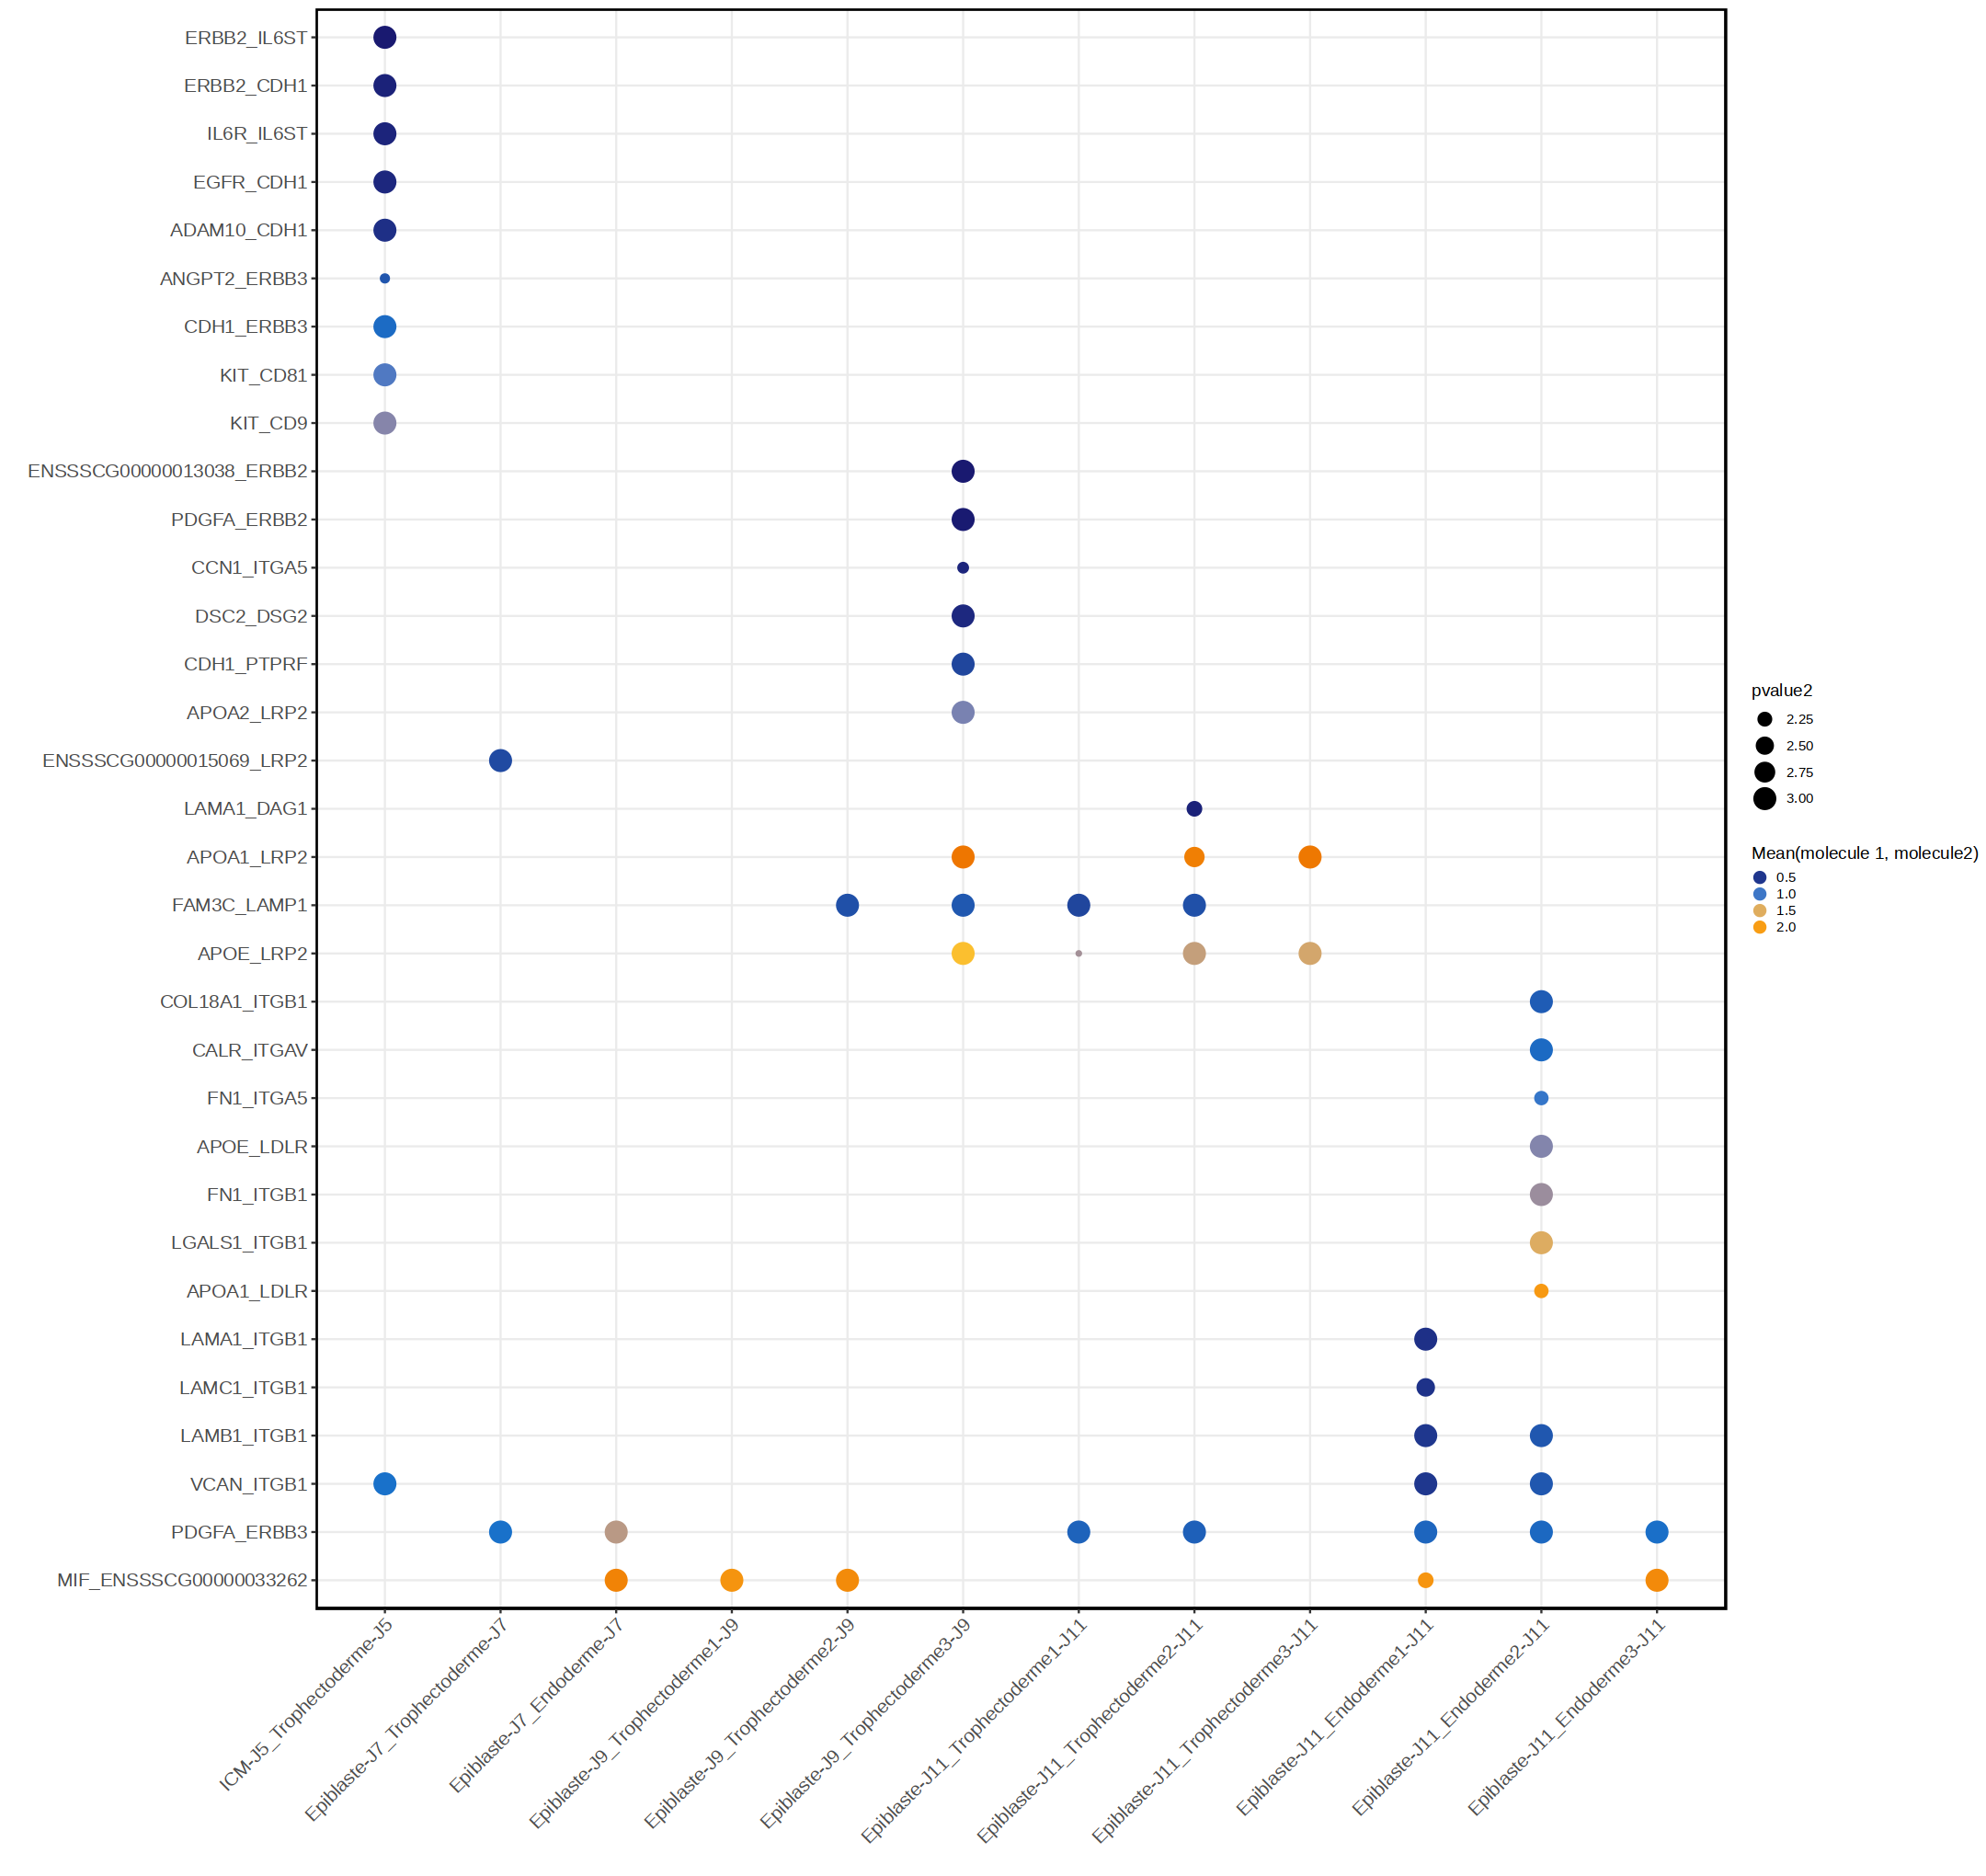

In [24]:
print(gene.pairs$plot)

In [25]:
x <- gene.pairs$markers
head(x, n = 3)

,celltype1,celltype2,pair,ligand,receptor,mean.ligand,mean.receptor,mean,celltypes,split,pvalue,population,gene,pvalue2
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<dbl>
Epiblaste-J11_Endoderme1-J11.MIF_ENSSSCG00000033262_Epiblaste-J11_Endoderme1-J11,Epiblaste-J11,Endoderme1-J11,MIF_ENSSSCG00000033262,MIF,ENSSSCG00000033262,1.6483444,2.5097366,2.0790405,Epiblaste-J11_Endoderme1-J11,MIF_ENSSSCG00000033262_Epiblaste-J11_Endoderme1-J11,0.004995005,Epiblaste-J11_Endoderme1-J11,MIF_ENSSSCG00000033262,2.301464
Epiblaste-J11_Endoderme1-J11.PDGFA_ERBB3_Epiblaste-J11_Endoderme1-J11,Epiblaste-J11,Endoderme1-J11,PDGFA_ERBB3,PDGFA,ERBB3,0.2846001,1.4355538,0.8600769,Epiblaste-J11_Endoderme1-J11,PDGFA_ERBB3_Epiblaste-J11_Endoderme1-J11,0.000999001,Epiblaste-J11_Endoderme1-J11,PDGFA_ERBB3,3.000434
Epiblaste-J11_Endoderme1-J11.VCAN_ITGB1_Epiblaste-J11_Endoderme1-J11,Epiblaste-J11,Endoderme1-J11,VCAN_ITGB1,VCAN,ITGB1,0.3577574,0.6564125,0.5070849,Epiblaste-J11_Endoderme1-J11,VCAN_ITGB1_Epiblaste-J11_Endoderme1-J11,0.000999001,Epiblaste-J11_Endoderme1-J11,VCAN_ITGB1,3.000434


In [26]:
sts2 <- list()
for(i in unique(x$celltypes)){
  tmp <- x[which(x$celltypes == i),]
  rs <- unique(tmp$receptor)
  sts2[["receptor"]][[i]]$sources <- rs  # receptors
  sts2[["receptor"]][[i]]$targets <- tfs # TFs (all)
}

In [27]:
wd_package <- "/home/adufour/work/FUSCA_result/FUSCA_pigs"
setwd(wd_package)
maindir <- paste0(wd_package, '')

In [28]:
interaction_df <- as.data.frame(import_omnipath_interactions(datasets = 'omnipath', entity_types = 'protein'))

In [29]:
interactions_source_convert <- gorth(query = interaction_df$source_genesymbol, source_organism = "hsapiens",
target_organism = "sscrofa", mthreshold = 1, filter_na = FALSE, numeric_ns = "ENTREZGENE_ACC")

In [30]:
interactions_target_convert <- gorth(query = interaction_df$target_genesymbol, source_organism = "hsapiens",
target_organism = "sscrofa", mthreshold = 1, filter_na = FALSE, numeric_ns = "ENTREZGENE_ACC")

In [31]:
interactions_source_convert <- interactions_source_convert[!duplicated(interactions_source_convert$input_number),]
interactions_target_convert <- interactions_target_convert[!duplicated(interactions_target_convert$input_number),]

In [32]:
interaction_df$source_genesymbol <- interactions_source_convert$ortholog_name
interaction_df$target_genesymbol <- interactions_target_convert$ortholog_name
head(interaction_df)

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<int>
1,P0DP25,P48995,CALM3,TRPC1,1,0,1,1,0,1,TRIP,TRIP:11290752;TRIP:11983166;TRIP:12601176,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,1
2,P0DP23,P48995,CALM3,TRPC1,1,0,1,1,0,1,TRIP,TRIP:11290752;TRIP:11983166;TRIP:12601176,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,1
3,P0DP24,P48995,ENSSSCG00000009126,TRPC1,1,0,1,1,0,1,TRIP,TRIP:11290752;TRIP:11983166;TRIP:12601176,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,1
4,Q03135,P48995,CAV1,TRPC1,1,1,0,1,1,0,DIP;HPRD;IntAct;Lit-BM-17;TRIP,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit-BM-17:10980191;Lit-BM-17:19052258;Lit-BM-17:19897728;TRIP:12732636;TRIP:14551243;TRIP:16822931;TRIP:18430726;TRIP:19052258;TRIP:19351713;TRIP:19897728,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit-BM-17:10980191;Lit-BM-17:19052258;Lit-BM-17:19897728;TRIP:12732636;TRIP:14551243;TRIP:16822931;TRIP:18430726;TRIP:19052258;TRIP:19351713;TRIP:19897728,5
5,P14416,P48995,DRD2,TRPC1,1,1,0,1,1,0,TRIP,TRIP:18261457,1,TRIP:18261457,1
6,Q99750,P48995,MDFI,TRPC1,1,0,1,1,0,1,HPRD;TRIP,HPRD:14530267;TRIP:14530267;TRIP:23770672,3,HPRD:14530267;TRIP:14530267;TRIP:23770672,2


In [34]:
inetwork <- createPPI(expr = cellrouter@assays$RNA@ndata, data = interaction_df)

37689 15
Protein interaction data loaded!

In [35]:
corTables <- cellnetworksPPI2(ppi = inetwork$network, expr = cellrouter@assays$RNA@ndata, 
                              samples = cellrouter@assays$RNA@sampTab, column = "celltype", 
                              corThr1 = 0.05, corThr2 = 0.05, dir.prefix = "/home/adufour/work/FUSCA_result/FUSCA_pigs/")

[1] "ICM-J5"
[1] -0.6004  1.0000
[1] "Trophectoderme-J5"
[1] -0.616382  1.000000
[1] "Trophectoderme-J7"
[1] -0.5815098  1.0000000
[1] "Endoderme-J7"
[1] -0.4148808  1.0000000
[1] "Epiblaste-J7"
[1] -0.4316445  1.0000000
[1] "Endoderme-J9"
[1] -0.5376494  1.0000000
[1] "Trophectoderme3-J9"
[1] -0.3277548  1.0000000
[1] "Epiblaste-J9"
[1] -0.4974247  1.0000000
[1] "Trophectoderme2-J9"
[1] -0.3568546  1.0000000
[1] "Trophectoderme1-J9"
[1] -0.740279  1.000000
[1] "Endoderme1-J11"
[1] -0.2995086  1.0000000
[1] "Trophectoderme1-J11"
[1] -0.3156327  1.0000000
[1] "Endoderme2-J11"
[1] -0.4148251  1.0000000
[1] "Trophectoderme2-J11"
[1] -0.336664  1.000000
[1] "Mesendoderme-J11"
[1] -0.6298149  1.0000000
[1] "Endoderme3-J11"
[1] -0.180028  1.000000
[1] "Epiblaste-J11"
[1] -0.5418892  1.0000000
[1] "Trophectoderme3-J11"
[1] -0.7530744  1.0000000


In [36]:
interactionList <- tumor
cellcomm <- CreateCellComm()

[1] "Initializing CellComm object"


In [37]:
interactionList <- c('ICM-J5_Trophectoderme-J5', 'Epiblaste-J7_Trophectoderme-J7', 'Epiblaste-J7_Endoderme-J7', 'Epiblaste-J9_Trophectoderme3-J9',
                     'Epiblaste-J11_Trophectoderme2-J11', 'Epiblaste-J11_Trophectoderme3-J11', 'Epiblaste-J11_Endoderme2-J11', 'Epiblaste-J11_Endoderme3-J11')

In [38]:
cellcomm <- CreateCellComm()
for(interaction in interactionList){
  interaction <- gsub(" ", ".", interaction)
  print(interaction)
  celltype <- strsplit(interaction, split = "[_]")[[1]][2]
  
  cat("Using ", celltype, " coexpression network\n")
  filename <- paste(celltype, ".txt", sep='')
  dirname <- gsub(("[.]"), ".", interaction)
  cellcomm <- findpaths.simpleRJava(cellcomm, sources.targets = sts2$receptor[[interaction]], file = filename, dir = dirname, maindir = maindir)
}

[1] "Initializing CellComm object"
[1] "ICM-J5_Trophectoderme-J5"
Using  Trophectoderme-J5  coexpression network
[1] "Trophectoderme-J5.txt"
[1] "/home/adufour/work/FUSCA_result/FUSCA_pigs"
[1] "NET=//home/adufour/work/FUSCA_result/FUSCA_pigs/Trophectoderme-J5.txt"
[1] "Epiblaste-J7_Trophectoderme-J7"
Using  Trophectoderme-J7  coexpression network
[1] "Trophectoderme-J7.txt"
[1] "/home/adufour/work/FUSCA_result/FUSCA_pigs"
[1] "NET=//home/adufour/work/FUSCA_result/FUSCA_pigs/Trophectoderme-J7.txt"
[1] "Epiblaste-J7_Endoderme-J7"
Using  Endoderme-J7  coexpression network
[1] "Endoderme-J7.txt"
[1] "/home/adufour/work/FUSCA_result/FUSCA_pigs"
[1] "NET=//home/adufour/work/FUSCA_result/FUSCA_pigs/Endoderme-J7.txt"
[1] "Epiblaste-J9_Trophectoderme3-J9"
Using  Trophectoderme3-J9  coexpression network
[1] "Trophectoderme3-J9.txt"
[1] "/home/adufour/work/FUSCA_result/FUSCA_pigs"
[1] "NET=//home/adufour/work/FUSCA_result/FUSCA_pigs/Trophectoderme3-J9.txt"
[1] "Epiblaste-J11_Trophectoderme2-J11"

In [39]:
files <- list()
for(i in interactionList){
  f <- paste(strsplit(i, split = "_")[[1]][2], ".txt", sep = "")
  files[[i]] <- f
}

In [40]:
summarize.flow <- function(files, prefix){
  gs <-list()
  nodes <- list()
  edges <- list()
  paths <- list()
  for(sub in names(files)){
    sub <- gsub(('[ ]'), "_", sub)
    cat(sub, '\n')

    folder <- file.path("/work/adufour/FUSCA_result/FUSCA_pigs", prefix, sub, 'FlowNetwork_all_paths_subnet.gml')
    x <- file.path("/work/adufour/FUSCA_result/FUSCA_pigs", prefix, sub, 'FlowNetwork_all_paths.txt')

    path <- read.csv(x, sep='\t')
    path <- path[!duplicated(as.vector(path$path)),]
    path <- path[order(path$rank),]
    if(nrow(path) > 0){
      gml <- igraph::read.graph(folder, format="gml")
      gs[[sub]] <- gml
      category <- igraph::V(gml)$props
      flow <- igraph::V(gml)$totalFlows
      names(category) <- igraph::V(gml)$name
      names(flow) <- igraph::V(gml)$name

      node <- data.frame(category = category, flow = flow)
      node <- node[order(node$flow, decreasing = TRUE), ]

      # Try to integrate mean total flow to the score...
      df <- data.frame()
      i <- 1
      for(p in as.vector(path$path)){
        genes <- strsplit(p, split='->', fixed=TRUE)[[1]]
        genes <- genes[-c(1, length(genes))]
        df[i,'path'] <- p
        df[i, 'meanflow'] <- mean(node[genes, 'flow'])
        i <- i + 1
      }
      path$meanflow <- as.numeric(df$meanflow)

      edge <- as.data.frame(igraph::get.edgelist(gml))
      edge <- cbind(edge, weight = igraph::E(gml)$weight,
                    corr= igraph::E(gml)$correlation)
      edge <- edge[order(edge$weight, decreasing = TRUE),]

      nodes[[sub]] <- node
      edges[[sub]] <- edge
      paths[[sub]] <- path
    }
  }
  aux <- list(nodes=nodes, edges=edges, paths=paths, gml=gs)
  return(aux)
}

In [41]:
summary <- summarize.flow(files, prefix = "")

ICM-J5_Trophectoderme-J5 
Epiblaste-J7_Trophectoderme-J7 
Epiblaste-J7_Endoderme-J7 
Epiblaste-J9_Trophectoderme3-J9 
Epiblaste-J11_Trophectoderme2-J11 
Epiblaste-J11_Trophectoderme3-J11 
Epiblaste-J11_Endoderme2-J11 
Epiblaste-J11_Endoderme3-J11 


In [42]:
grn_scenic <- read.table(file = '/home/adufour/work/scenic/scenic_pig/direct_annot_v6/out/scenic/10x_PBMC/arboreto_with_multiprocessing/run_1/10x_PBMC__run_1__adj.tsv', sep = '\t', header = TRUE)

In [43]:
grn_scenic_TF <- gconvert(
grn_scenic$TF,
organism = "sscrofa",
numeric_ns = "",
mthreshold = 1,
filter_na = TRUE
)

Warning message in nchar(str, "bytes") * 4L:
“NA produit par débordement d'entier par le haut”


In [44]:
grn_scenic_target <- gconvert(
grn_scenic$target,
organism = "sscrofa",
numeric_ns = "",
mthreshold = 1,
filter_na = FALSE
)

Warning message in nchar(str, "bytes") * 4L:
“NA produit par débordement d'entier par le haut”


In [45]:
grn_scenic$TF <- grn_scenic_TF$name

In [46]:
grn_scenic$target <- grn_scenic_target$name

In [47]:
colnames(grn_scenic) <- c("reg", "target", "importance", "regulation", "corr")
sampTab <- cellrouter@sampTab

In [48]:
apathways <- activeSignaling(data = cellrouter@assays$RNA@ndata, sampTab = cellrouter@assays$RNA@sampTab, grn = grn_scenic, markers = markers, summary = summary, fc = 0.2)
npaths <- rankpaths(summary, apathways$pathways)

[1] "Trophectoderme-J5"
SUB:  ICM-J5_Trophectoderme-J5  SEED:  ITGB1 IL6ST CDH1 ERBB3 CD81 CD9 
SUB:  ICM-J5_Trophectoderme-J5  TARGETS:  STAT3 NFKB2 DLX3 GATA4 RXRA FOXA2 GATA1 NANOG MAX CEBPB FOSL1 
STAT3 :  89 	 5181 5 	  5.343545e-05 
DLX3 :  76 	 3573 5 	  2.443704e-07 
GATA4 :  99 	 6324 5 	  0.001396851 
GATA1 :  19 	 2747 5 	  0.002008265 
NANOG :  108 	 7131 5 	  0.0003404796 
MAX :  129 	 6490 5 	  3.705408e-15 
CEBPB :  115 	 6195 5 	  9.320883e-10 
______________________________
[1] "Trophectoderme-J7"
SUB:  Epiblaste-J7_Trophectoderme-J7  SEED:  LRP2 ERBB3 
SUB:  Epiblaste-J7_Trophectoderme-J7  TARGETS:  PPARG SMAD3 STAT3 CEBPB ELF3 RARA ZNF148 NR2C2 GATA1 KLF13 
STAT3 :  39 	 5181 5 	  0.005955253 
CEBPB :  104 	 6195 5 	  2.814824e-10 
ELF3 :  128 	 5962 5 	  8.262178e-28 
RARA :  35 	 2175 5 	  0.01886598 
GATA1 :  47 	 2747 5 	  0.0009645588 
KLF13 :  82 	 5125 5 	  1.083368e-05 
______________________________
[1] "Endoderme-J7"
SUB:  Epiblaste-J7_Endoderme-J7  SEED:  